# MultiVelo Fig4

Data for this figure can be found at the links below:

RNA: https://figshare.com/account/projects/164296/articles/22575307

ATAC: https://figshare.com/account/projects/164296/articles/22575313

If you do not download them manually, the notebook will do so automatically.

In [1]:
import os
import scipy
import numpy as np
import pandas as pd
import math
import sys
import multivelo as mv
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt
import requests
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.set_figure_params('scvelo')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
np.set_printoptions(suppress=True)

In [3]:
rna_url = "https://figshare.com/ndownloader/files/40064275"
atac_url = "https://figshare.com/ndownloader/files/40064278"
  
rna_path = "adata_postpro.h5ad"
atac_path = "adata_atac_postpro.h5ad"

In [4]:
adata_rna = sc.read(rna_path, backup_url=rna_url)
adata_atac = sc.read(atac_path, backup_url=atac_url)

  0%|          | 0.00/96.8M [00:00<?, ?B/s]

  0%|          | 0.00/68.4M [00:00<?, ?B/s]

## Running multi-omic dynamical model

MultiVelo incorporates chromatin accessibility information into RNA velocity and achieves better lineage predictions.

The detailed argument list can be shown with "help(mv.recover_dynamics_chrom)".

### WARNING:

The recover_dynamics_chrom() step can take a long time, even with parallelization. As such, we added a h5ad file to figshare containing the AnnData object returned by recover_dynamics_chrom(). In absence of a local h5ad file of the same name, a cell below the recover_dynamics_chrom() step will download it automatically using sc.read(). If you want to run this notebook in shorter amount of time, then you can run that cell first and skip the preprocessing done in the cells above it. However, if you want to run all cells, including the preprocessing steps, the notebook will write and save the h5ad file itself rather than downloading it from figshare.

recovering dynamics (using 1/10 cores)


  0%|          | 0/141 [00:00<?, ?gene/s]

    finished (0:01:23) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


  0%|          | 0/6436 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 5 regions of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)
computing velocity embedding
    finished (0:00:03) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


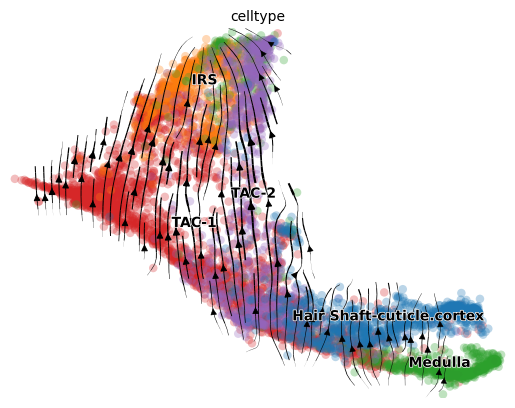

In [5]:
scv.tl.recover_dynamics(adata_rna)
scv.tl.velocity(adata_rna, mode="dynamical")
scv.tl.velocity_graph(adata_rna, n_jobs=1)
scv.tl.latent_time(adata_rna)
scv.pl.velocity_embedding_stream(adata_rna, basis='umap', color='celltype')

In [6]:
# This will take a while. Parallelization is high recommended.

adata_result = mv.recover_dynamics_chrom(adata_rna, 
                                        adata_atac,
                                        max_iter=5, 
                                        init_mode="invert", 
                                        verbose=False,
                                        parallel=True,
                                        n_jobs = 15,
                                        save_plot=False,
                                        rna_only=False,
                                        fit=True,
                                        n_anchors=500, 
                                        extra_color_key='celltype'
                                        )

  0%|          | 0/962 [00:00<?, ?it/s]

In [7]:
# Save the result for use later on
adata_result.write("multivelo_result_fig4.h5ad")

In [3]:
h5ad_url = "https://figshare.com/ndownloader/files/40064263"
adata_result = sc.read("multivelo_result_fig4.h5ad", backup_url = h5ad_url)

In [4]:
print(adata_result)

AnnData object with n_obs × n_vars = 6436 × 960
    obs: 'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'mean', 'std', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes', 'fit_alpha_c', 'fit_t_sw1', 'fit_t_sw2', 'fit_t_sw3', 'fit_scale_cc', 'fit_rescale_c', 'fit_rescale_u', 'fit_model', 'fit_direction', 'fit_loss', 'fit_likelihood_c', 'fit_ssd_c', 'fit_var_c', 'fit_c

## Computing velocity stream and latent time

In [5]:
mv.velocity_graph(adata_result)
mv.latent_time(adata_result)

computing velocity graph (using 1/10 cores)


  0%|          | 0/6436 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'velo_s_norm_graph', sparse matrix with cosine correlations (adata.uns)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


## Fig 4a

computing velocity embedding
    finished (0:00:02) --> added
    'velo_s_norm_umap', embedded velocity vectors (adata.obsm)


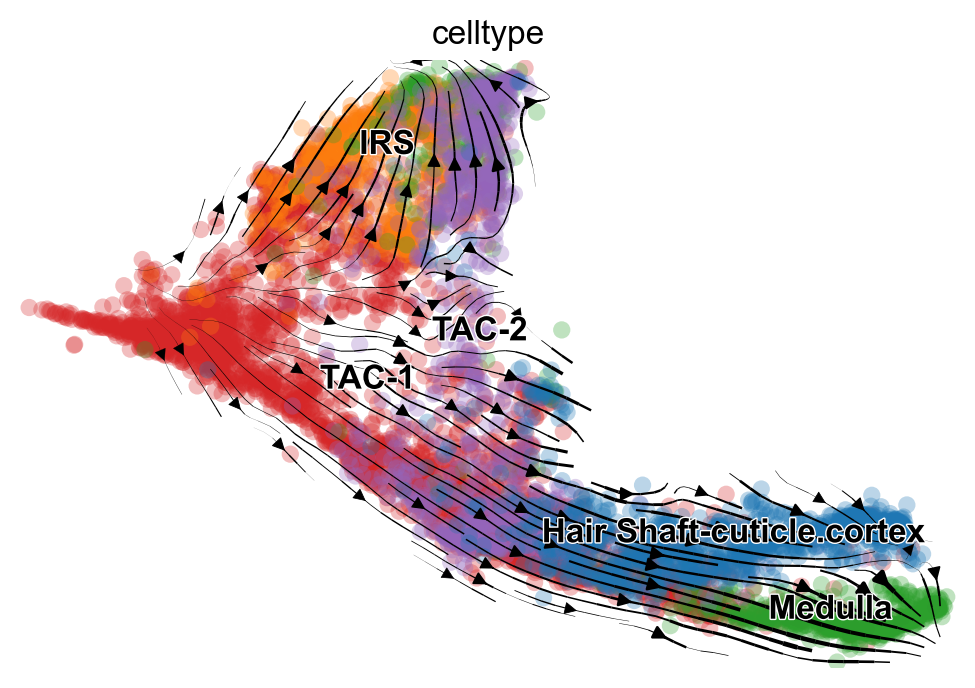

In [6]:
mv.velocity_embedding_stream(adata_result, basis='umap', color='celltype', show=True)

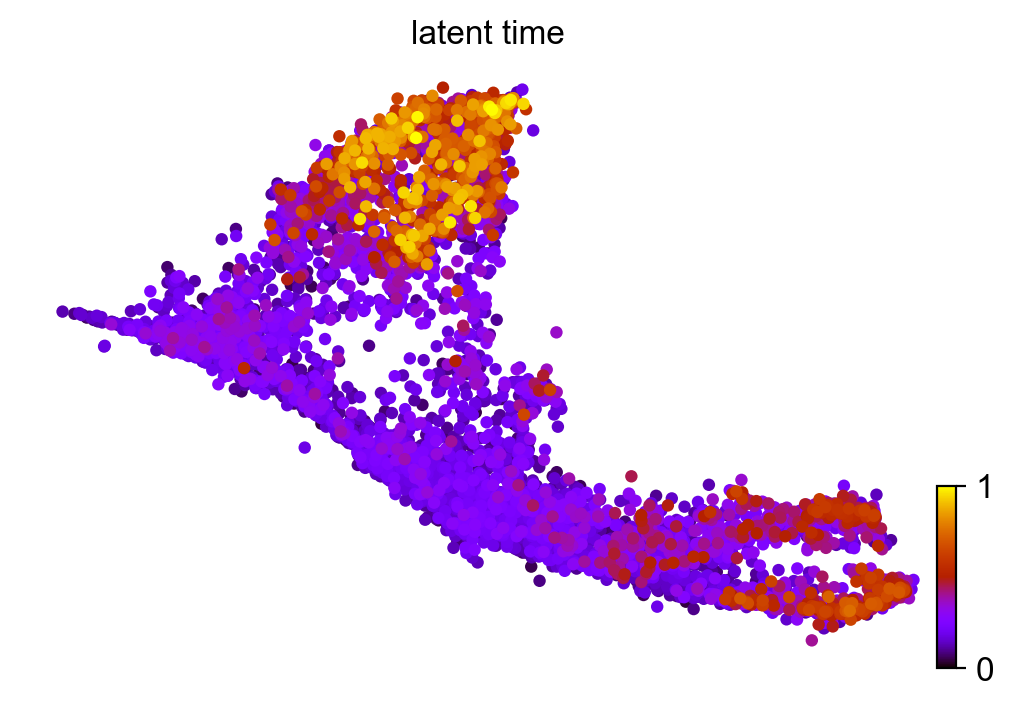

In [7]:
scv.pl.scatter(adata_result, color='latent_time', color_map='gnuplot', size=80)

## Fig 4b

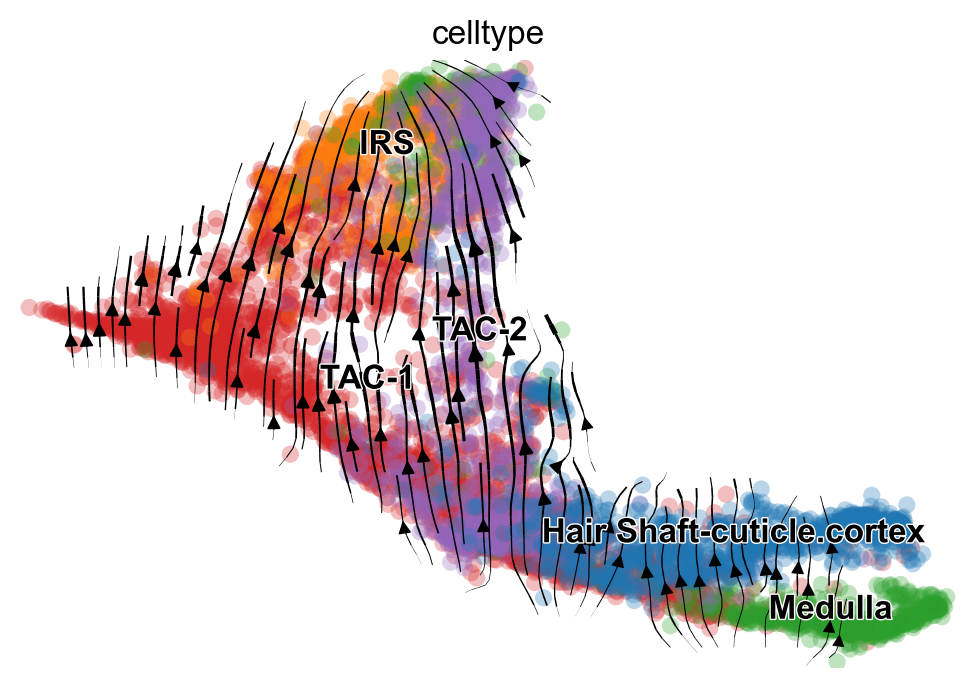

In [8]:
scv.pl.velocity_embedding_stream(adata_result, basis='umap', color='celltype')

## Fig 4c

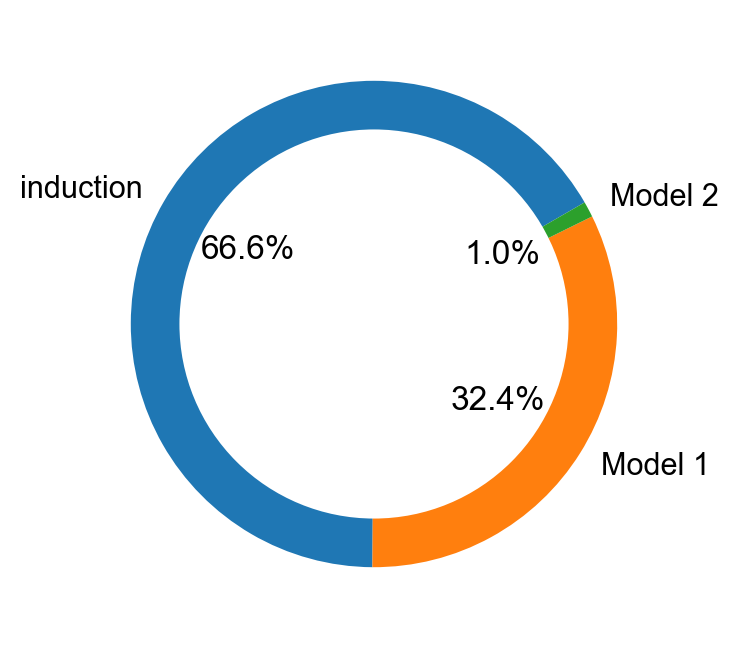

In [9]:
mv.pie_summary(adata_result)

## Fig 4d

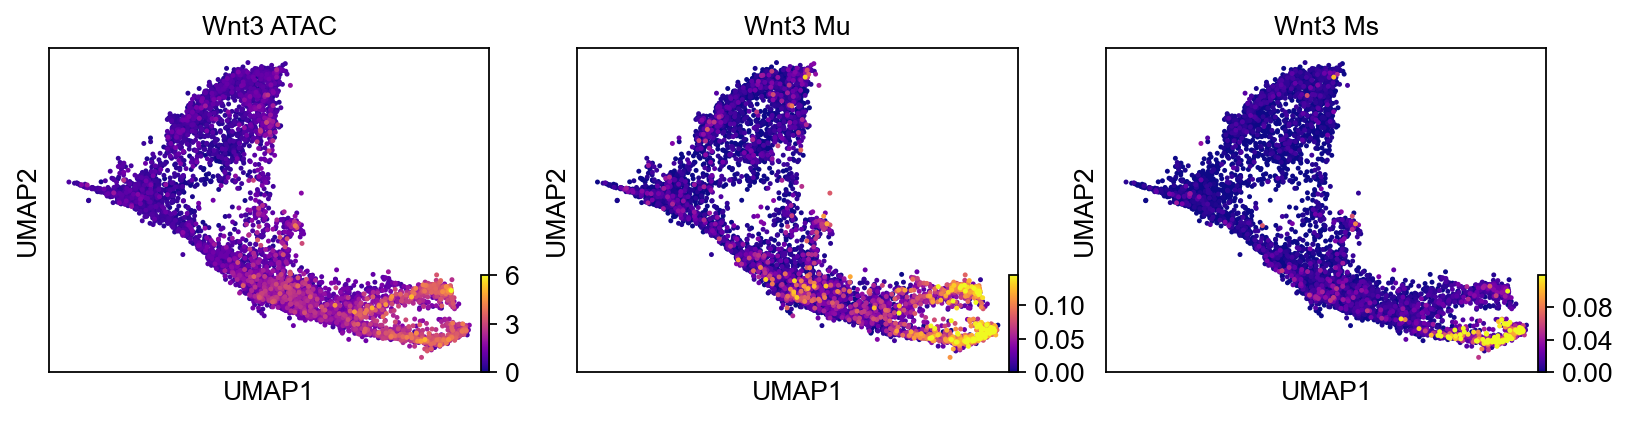

In [10]:
layers = ["ATAC", "Mu", "Ms"]

gene="Wnt3"

titles = []
for layer in layers:
    titles.append(gene + " " + layer)
scv.pl.scatter(adata_result, color=gene, layer=layers, color_map="plasma", size=20, frameon=True, title=titles)

## Fig 4e

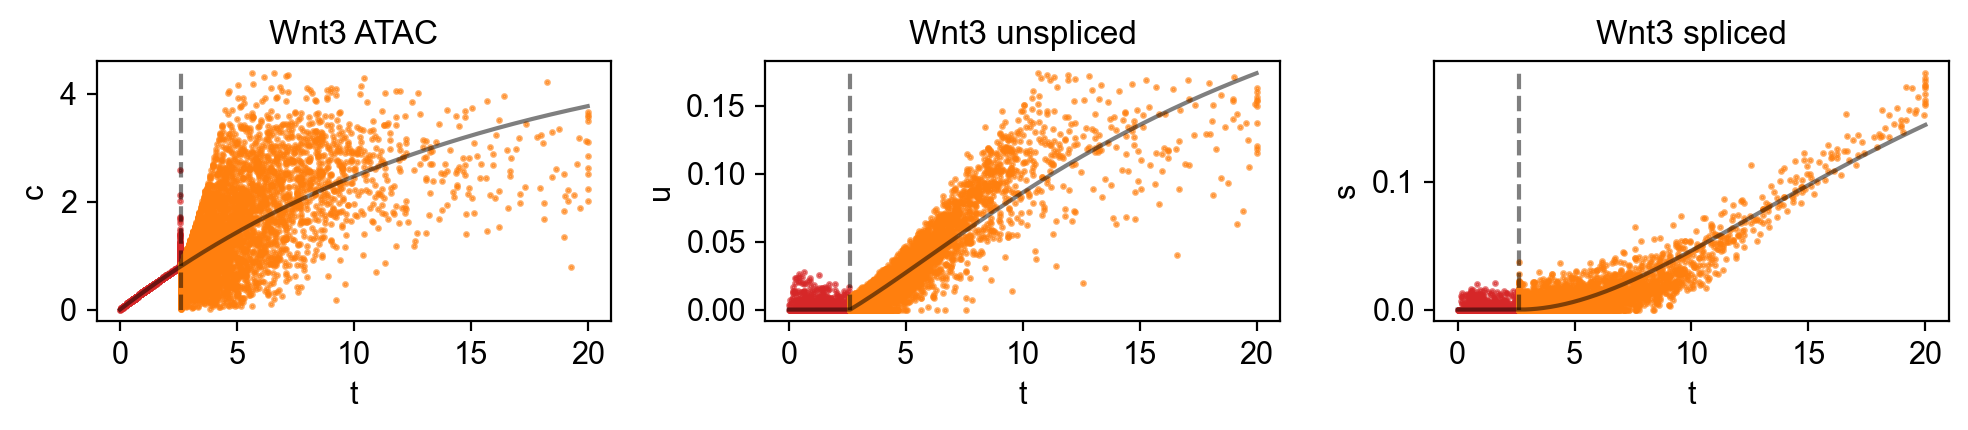

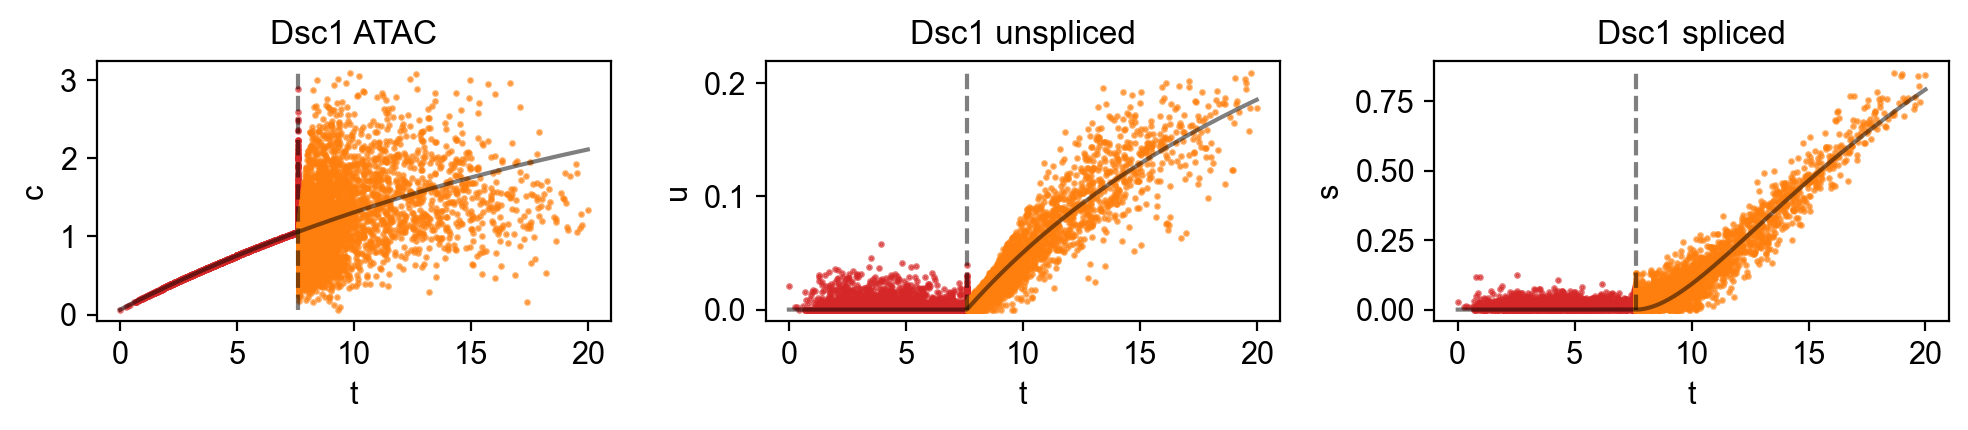

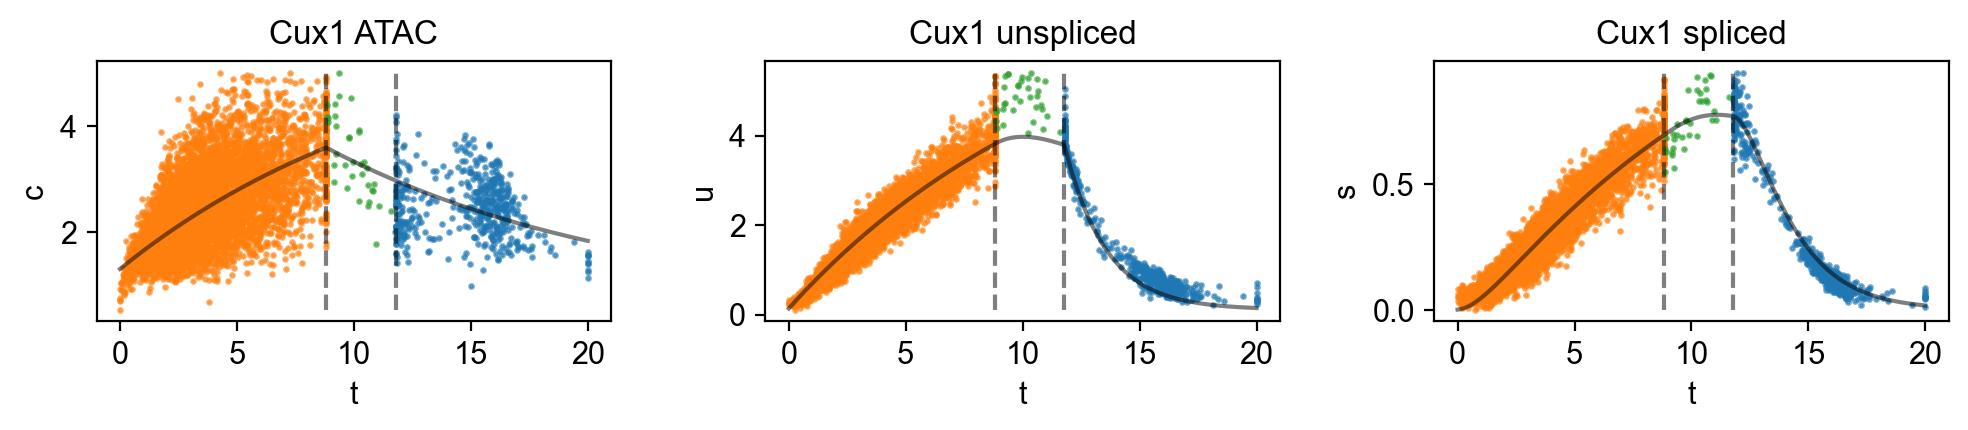

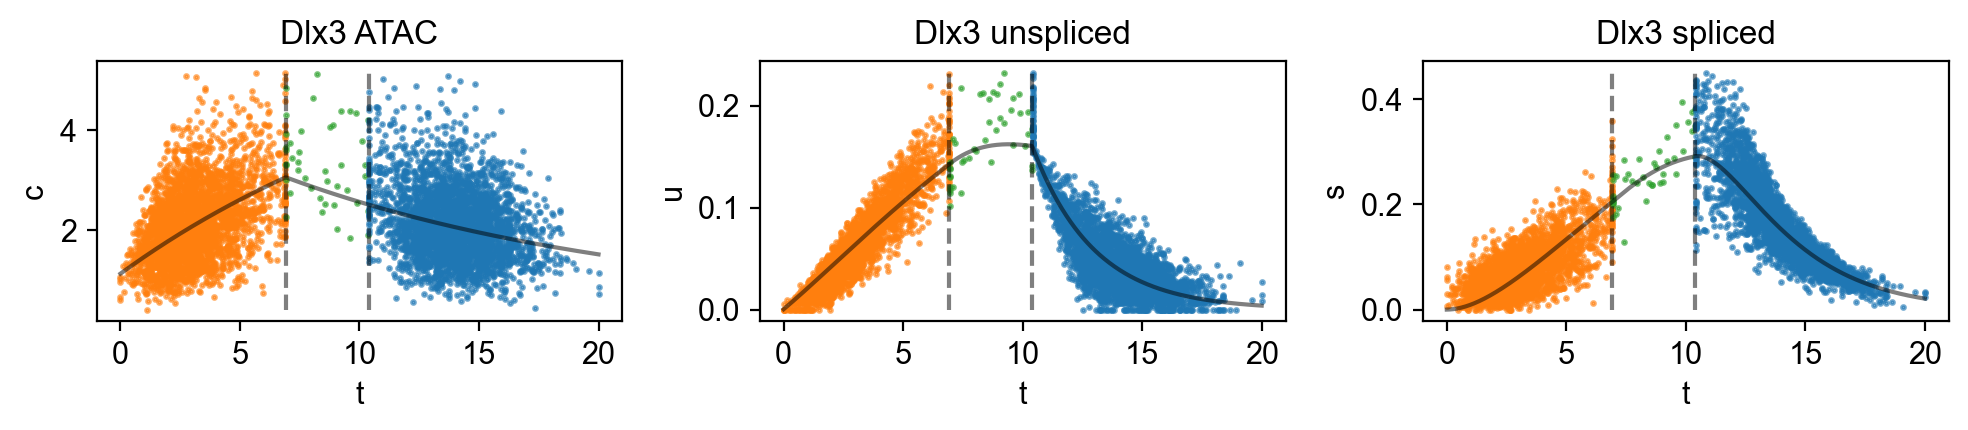

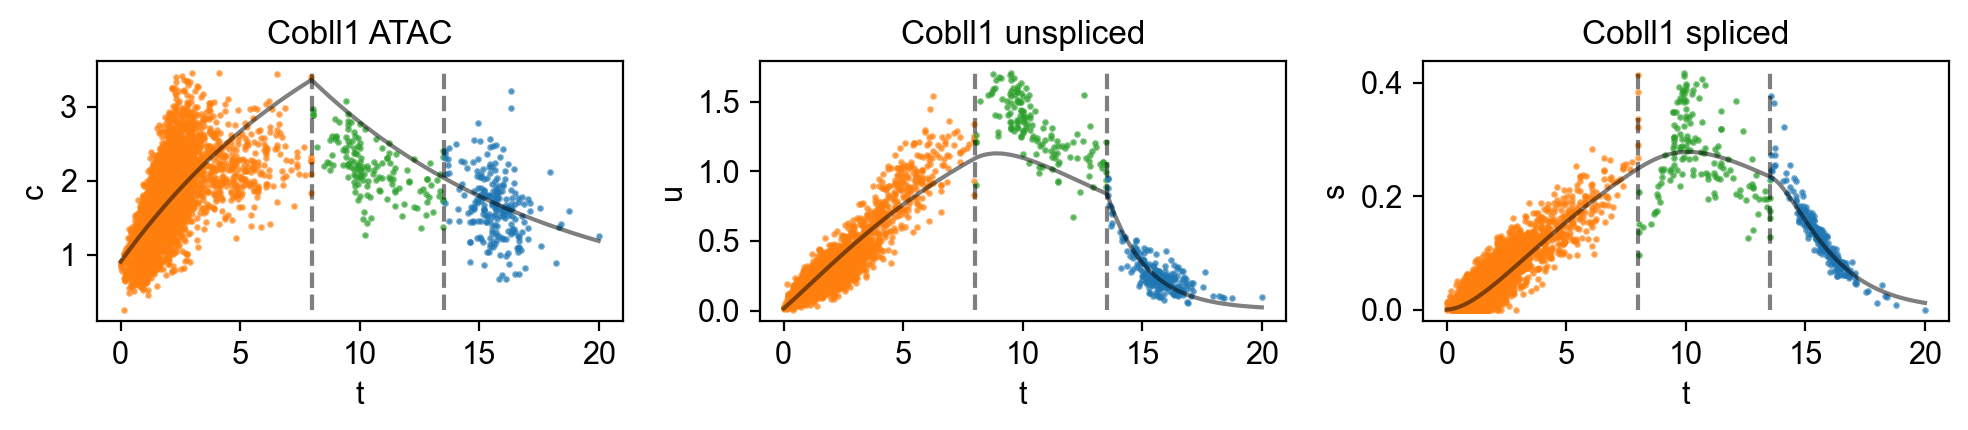

In [11]:
genes = ["Wnt3", "Dsc1", "Cux1", "Dlx3", "Cobll1"]

for gene in genes:
    mv.dynamic_plot(adata_result, genes=gene, color_by="state")

## Fig 4f

In [12]:
from pandas import DataFrame

# preprocess the data before we perform Dynamic Time Warping

# arr = an array of non-time data
# time = time data
# bins = the number of bins we want to put the data into
def preprocess(arr, time, bins):
    
    # normalize the time data
    new_time = time / max(time)
    
    # multiply the time data by the number of bins we want
    new_time = new_time*bins
    
    # make an arrow of the time data converted into integer bins
    arr_window = np.floor(new_time)
    
    # group our non-time data into our time bins and take the mean
    df = DataFrame({'arr': arr, 'window': arr_window})
    arr_df = df.groupby(['window'], group_keys=False).mean()
    
    # our binned data
    arr2 = np.array(arr_df['arr'])
    
    # our time bins
    arr_t = np.arange(-1, bins, 1)
    
    # normalize our non-time data
    arr_vec = arr2 - min(arr2)
    arr_vec = arr_vec / max(arr_vec)
    
    return arr_t, arr_vec

In [13]:
bins = 20

# get the c, u, and s data
c = np.array(adata_result[:, "Wnt3"].layers["ATAC"])[:,0]
u = np.array(adata_result[:, "Wnt3"].layers["Mu"])[:,0]
s = np.array(adata_result[:, "Wnt3"].layers["Ms"])[:,0]

# get our time data
t = np.array(adata_result[:, "Wnt3"].layers["fit_t"])[:,0]

# do preprocessing steps
ct, c_a = preprocess(c, t, bins)
ut, u_a = preprocess(u, t, bins)
st, s_a = preprocess(s, t, bins)

<Axes: xlabel='Index', ylabel='Query value'>

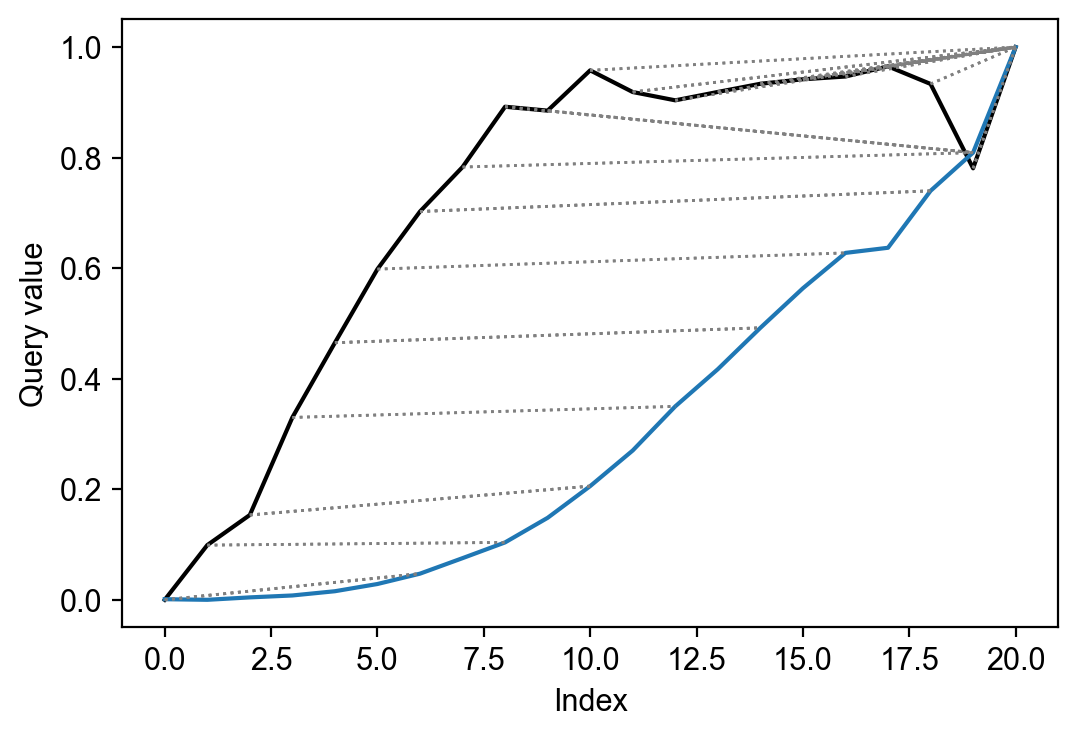

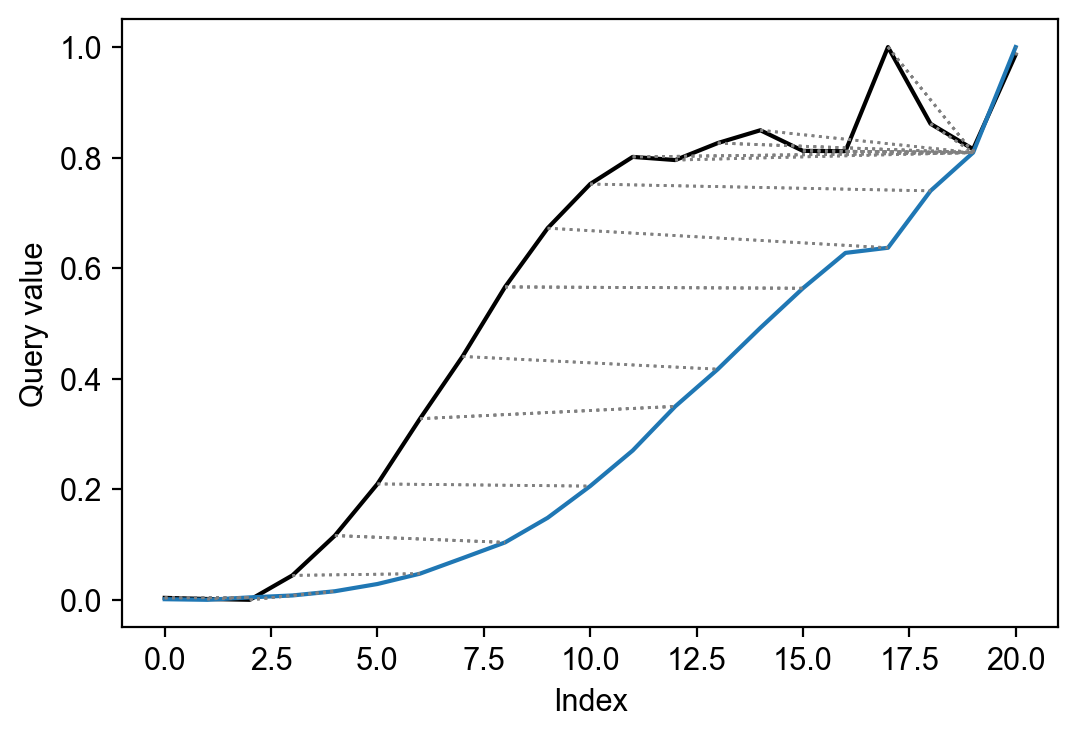

In [14]:
# perform DTW for the data and plot
cs_aligned = dtw(c_a, s_a, keep_internals=True, open_end=True, open_begin=True, step_pattern="asymmetric")
cs_aligned.plot(type="twoway", label=["c", "s"])

us_aligned = dtw(u_a, s_a, keep_internals=True, open_end=True, open_begin=True, step_pattern="asymmetric")
us_aligned.plot(type="twoway")

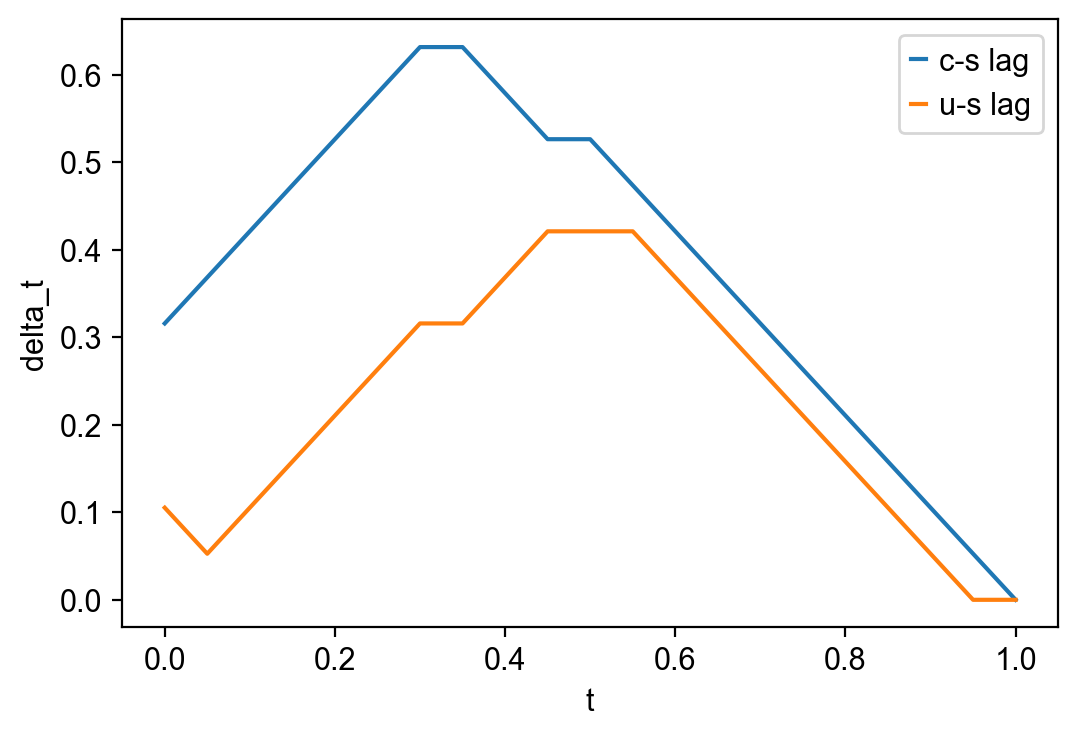

In [15]:
# get the indeces for matching our c values to the s values in our cs plot
c_pts = cs_aligned.index1
cs_pts = cs_aligned.index2 # <- s values for the cs plot

# get the indeces for matching our u values to the s values in our us plot
u_pts = us_aligned.index1
us_pts = us_aligned.index2 # <- s values for the us plot

# normalize the time data for c, s, and u
ct_norm = ct / max(ct)
st_norm = st / max(st)
ut_norm = ut / max(ut)

# subtract the time values for the aligned points on the two graphs
cs_lag = st_norm[cs_pts] - ct_norm[c_pts]
us_lag = st_norm[us_pts] - ut_norm[u_pts]

# corresponding time values for each delta t on the graph
graph_t = np.linspace(0, 1, num=21)

# plot
plt.plot(graph_t, cs_lag, label="c-s lag")
plt.plot(graph_t, us_lag, label="u-s lag")
plt.ylabel("delta_t")
plt.xlabel("t")
plt.legend()